# Comparing IPO with equity market

- 1) Organize IPO and equity date
- 2) Import IPO and equity date
- 3) Define functions for matching firms and calculating return
- 4) Compare returns between IPO with MatchFirm
- 5) Discussion

### Result: There is a slight bias of $\sim 0.1\sigma$ towards IPO return ($\sim 200$ samples) after holding for just one year. This bias seems to increase over time, and results in a stronger bias of $\sim 0.6\sigma$ towards IPO return ($\sim 50$ samples)  after holding for three years. The increase is not simply due to compounding; there exists some kind of acceleration.

In [1]:
import pandas as pd
import numpy as np

## 1) Organize IPO and equity data

In [2]:
# Organize data for IPO price
bb_data = pd.read_csv('data/bloomberg_full_data copy.csv')

# Get IPO date, price and market capitalization
bb_data = bb_data[['STOCK_CODE', 'DATE', 'BLOOMBERG_CLOSE_PRICE','CUR_MKT_CAP']]
bb_data = bb_data.drop_duplicates()

# Arrange by date
ipo_price = pd.DataFrame(columns=bb_data['DATE'].unique())
for stock in bb_data['STOCK_CODE'].unique():
    data = bb_data[bb_data["STOCK_CODE"] == stock]
    timeSeries = pd.DataFrame([data['BLOOMBERG_CLOSE_PRICE'].to_list() + [str(stock)]], columns=(data['DATE'].to_list() + ['Stock']))
    ipo_price = pd.concat([ipo_price, timeSeries], ignore_index=True)

ipo_price = ipo_price.iloc[:, ::-1]

# Limit sample to 2020-01-01
end = ipo_price.columns.get_loc('2020-01-01')
ipo_price = ipo_price.iloc[:, :end+1]

In [3]:
# Organize data for equity market capitalization
eqt_mktcap = pd.read_csv('data/eqt_mktcap.csv', index_col=0)

# Get equity RIC and sector
sector = pd.read_excel('data/hkmkt_equity_industry_name (1).xlsm','Sheet1', usecols=['Type','TR1N'])
eqt_RIC = pd.read_csv('data/eqt_RIC.csv', usecols=['Type','RIC'])

eqt_mktcap['Name'] = eqt_RIC['RIC']
eqt_mktcap['Name'] = eqt_mktcap['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_mktcap.insert(1, 'Economic Sector', sector['TR1N'])

# Reduce sample to 2013-12-31
start = eqt_mktcap.columns.get_loc('2013-12-31')
eqt_mktcap = pd.concat([eqt_mktcap['Name'], eqt_mktcap['Economic Sector'], eqt_mktcap.iloc[:, start:]], axis=1)

In [4]:
# Select year-end market capitalization
select = ['Name','Economic Sector','2013-12-31','2014-12-31','2015-12-31','2016-12-30','2017-12-29','2018-12-31']
mktcap = eqt_mktcap.reindex(columns=select)
mktcap.columns=['Name','Economic Sector','2013','2014','2015','2016','2017','2018']

In [5]:
# Organize data for equity price
p = pd.read_csv('data/price.csv', index_col=0)

# Get equity RIC and sector
p['Name'] = eqt_RIC['RIC']
p['Name'] = p['Name'].astype(str).str.replace('.0', '', regex=False)
p.insert(1, 'Economic Sector', sector['TR1N'])

# Reduce sample to 2013-12-31
start = p.columns.get_loc('2013-12-31')
p = pd.concat([p['Name'], p['Economic Sector'], p.iloc[:, start:]],axis=1)

## 2) Import IPO and equity data

In [6]:
# Import IPO general data
data_ipo = pd.read_csv('resources/data_ipo.csv')
data_ipo['Stock'] = data_ipo['Stock'].astype(str)
data_ipo['previous_year'] = data_ipo['previous_year'].astype(str)
data_ipo

,Stock,Industry,IPO,MktCap,IPO Year,previous_year
0,1353,Consumer Cyclicals,2014-09-01,160.79,2014,2013
1,1439,Basic Materials,2014-01-13,0.81,2014,2013
2,1247,Consumer Cyclicals,2014-01-15,2.81,2014,2013
3,3332,Consumer Cyclicals,2014-01-15,2.66,2014,2013
4,2080,Real Estate,2014-01-23,2.84,2014,2013
...,...,...,...,...,...,...
439,6049,Real Estate,2019-12-19,45.35,2019,2018
440,9928,Real Estate,2019-12-19,4.88,2019,2018
441,9909,Consumer Cyclicals,2019-12-30,10.06,2019,2018
442,9911,Consumer Cyclicals,2019-12-31,3.25,2019,2018


In [7]:
# Import IPO price data
ipo_price = pd.read_csv('resources/ipo_price.csv')
ipo_price['Stock'] = ipo_price['Stock'].astype(str)
ipo_price

,Stock,2014-01-01,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-13,...,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,2020-01-01
0,1353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,1439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,0.20,0.19,0.20,0.20,0.20,0.21,0.26,0.28,0.28
2,1247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,3332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,0.20,0.22,0.22,0.22,0.22,0.21,0.21,0.21,0.21
4,2080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.49,0.52,0.51,0.49,0.49,0.49,0.49,0.48,0.51,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,6049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.35,45.00,43.60,43.30,43.30,43.30,46.85,48.25,46.75,46.75
599,9928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.88,4.60,4.73,4.89,4.89,4.89,4.89,4.89,4.85,4.85
600,9909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,9.82,9.82
601,9911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,3.25


In [8]:
# Import equity market capitalization year data
eqt_mktcap = pd.read_csv('resources/eqt_mktcap_year.csv')
eqt_mktcap['Name'] = eqt_mktcap['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_mktcap

,Name,Economic Sector,2013,2014,2015,2016,2017,2018
0,700,Technology,920999.70,1054200.00,1434098.00,1797760.00,3856589.00,2989375.00
1,3690,Technology,NaN,NaN,NaN,NaN,NaN,208838.60
2,939,Financials,1406440.00,1531457.00,1276615.00,1435290.00,1731004.00,1553095.00
3,941,Technology,1616244.00,1849676.00,1791603.00,1683083.00,1622680.00,1542826.00
4,1299,Financials,468511.40,519746.60,561453.10,527469.70,804767.60,785008.50
...,...,...,...,...,...,...,...,...
3439,nan,NaN,39318.50,39318.50,39318.50,39318.50,39318.50,39318.50
3440,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3441,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3442,nan,NaN,6389.48,6389.48,6389.48,6389.48,6389.48,6389.48


In [9]:
# Import equity price data
eqt_price = pd.read_csv('resources/eqt_price.csv')
eqt_price['Name'] = eqt_mktcap['Name'].astype(str).str.replace('.0', '', regex=False)
eqt_price

,Name,Economic Sector,2013-12-31,2014-01-01,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,2020-01-01
0,700,Technology,98.903,98.903,100.883,98.783,99.103,98.783,100.283,98.583,...,375.60,375.20,377.80,376.80,376.80,376.80,384.00,383.20,375.60,375.60
1,3690,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.50,102.00,101.00,102.30,102.30,102.30,102.70,102.50,101.90,101.90
2,939,Financials,5.850,5.850,5.820,5.680,5.590,5.560,5.640,5.540,...,6.64,6.62,6.68,6.63,6.63,6.63,6.76,6.75,6.73,6.73
3,941,Technology,80.400,80.400,80.200,78.600,78.150,78.050,78.450,77.350,...,62.45,63.95,63.70,64.25,64.25,64.25,65.40,65.80,65.50,65.50
4,1299,Financials,38.900,38.900,39.350,38.450,38.100,37.750,37.700,37.700,...,80.15,79.90,79.20,79.40,79.40,79.40,80.95,82.15,81.80,81.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3440,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3441,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3442,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3) Define functions for matching firms and calculating return

In [10]:
from datetime import datetime, timedelta

In [11]:
def find_matching_firm(mktdf, industry, mktcap, year):
    
    sameIndustry = mktdf[mktdf['Economic Sector'] == industry]
    minDiff = float('inf')
    match = 'Name'
    
    for index, row in sameIndustry.iterrows():
        diff = abs(row[year] - mktcap)
        if diff < minDiff:
            minDiff = diff
            match = row['Name']
    
    return match

In [12]:
def calculate_return_hold(dailydf, stock, start, weeks):
    
    end = datetime.strptime(start,"%Y-%m-%d") + timedelta(weeks=weeks)
    end = end.strftime("%Y-%m-%d")
    
    i = dailydf.columns.get_loc(start)
    j = dailydf.columns.get_loc(end)
    
    hold = dailydf.loc[dailydf.iloc[:,0] == stock].iloc[:,i+1:j+1].values
    return np.prod(hold + 1) - 1

In [13]:
def calculate_return_regular(pricedf, stock, start, weeks):
    
    end = datetime.strptime(start,"%Y-%m-%d") + timedelta(weeks=weeks)
    end = end.strftime("%Y-%m-%d")
    
    i = pricedf.columns.get_loc(start)
    j = pricedf.columns.get_loc(end)
    
    start_price = pricedf.loc[pricedf.iloc[:,0] == stock].iloc[:, i].values[0]
    end_price = pricedf.loc[pricedf.iloc[:,0] == stock].iloc[:, j].values[0]
    return end_price/start_price - 1

## 4) Compare returns between IPO with MatchFirm

In [14]:
# Calculate daily return for IPO
ipo_daily_return = ipo_price[['Stock']].copy()
for i in range(len(ipo_price.columns)):
    if i < 2: continue
    ipo_daily_return[ipo_price.columns[i]] = (ipo_price.iloc[:, i] - ipo_price.iloc[:, i-1]) / ipo_price.iloc[:, i-1]

ipo_daily_return

,Stock,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-13,2014-01-14,...,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,2020-01-01
0,1353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,1439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052632,0.000000,-0.050000,0.052632,0.0,0.0,0.050000,0.238095,0.076923,0.0
2,1247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,3332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.111111,0.000000,0.100000,0.000000,0.0,0.0,-0.045455,0.000000,0.000000,0.0
4,2080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.020000,0.061224,-0.019231,-0.039216,0.0,0.0,0.000000,-0.020408,0.062500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,6049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.007718,-0.031111,-0.006881,0.0,0.0,0.081986,0.029883,-0.031088,0.0
599,9928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.057377,0.028261,0.033827,0.0,0.0,0.000000,0.000000,-0.008180,0.0
600,9909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023857,0.0
601,9911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [15]:
# Calculate daily return for equity
eqt_daily_return = eqt_price[['Name', 'Economic Sector']].copy()
for i in range(len(eqt_price.columns)):
    if i < 3: continue
    eqt_daily_return[eqt_price.columns[i]] = (eqt_price.iloc[:, i] - eqt_price.iloc[:, i-1]) / eqt_price.iloc[:, i-1]

eqt_daily_return

,Name,Economic Sector,2014-01-01,2014-01-02,2014-01-03,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-30,2019-12-31,2020-01-01
0,700,Technology,0.0,0.020020,-0.020816,0.003239,-0.003229,0.015185,-0.016952,0.008926,...,-0.005297,-0.001065,0.006930,-0.002647,0.0,0.0,0.019108,-0.002083,-0.019833,0.0
1,3690,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003880,-0.014493,-0.009804,0.012871,0.0,0.0,0.003910,-0.001947,-0.005854,0.0
2,939,Financials,0.0,-0.005128,-0.024055,-0.015845,-0.005367,0.014388,-0.017730,0.001805,...,0.001508,-0.003012,0.009063,-0.007485,0.0,0.0,0.019608,-0.001479,-0.002963,0.0
3,941,Technology,0.0,-0.002488,-0.019950,-0.005725,-0.001280,0.005125,-0.014022,0.005818,...,0.005636,0.024019,-0.003909,0.008634,0.0,0.0,0.017899,0.006116,-0.004559,0.0
4,1299,Financials,0.0,0.011568,-0.022872,-0.009103,-0.009186,-0.001325,0.000000,-0.002653,...,-0.014145,-0.003119,-0.008761,0.002525,0.0,0.0,0.019521,0.014824,-0.004260,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3440,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3441,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3442,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Helper function to create peers dataframe
def calculate_peers(data, peers, holdWeeks):
    
    for index, ipo in data[0].iterrows():
    
        name = ipo['Stock']
        industry = ipo['Industry']
        mktcap = ipo['MktCap']
        prevYear = ipo['previous_year']

        date = ipo['IPO']
        if datetime.strptime(date, "%Y-%m-%d") + timedelta(weeks=holdWeeks) > datetime.strptime("2020-01-01", "%Y-%m-%d"):
            continue

        match = find_matching_firm(data[1], industry, mktcap, prevYear)
        #matchReturn = calculate_return_regular(data[2], match, date, holdWeeks)
        matchReturn = calculate_return_hold(data[3], match, date, holdWeeks)
        #ipoReturn = calculate_return_regular(data[4], name, date, holdWeeks)
        ipoReturn = calculate_return_hold(data[5], name, date, holdWeeks)

        group = {'IPO': name,
                 'IPO return': ipoReturn,
                 'MatchFirm': match,
                 'MatchFirm return': matchReturn,
                 'Industry': industry,
                 'IPO Date': date}
        peers = peers.append(group, ignore_index=True)
    
    return peers

In [17]:
# Create DataFrame to compare peers
peersdf = pd.DataFrame(columns=['IPO','IPO return','MatchFirm','MatchFirm return', 'Industry', 'IPO Date'])

# Calculate return after some weeks of holding
data = [data_ipo, eqt_mktcap, eqt_price, eqt_daily_return, ipo_price, ipo_daily_return]
years = 3
holdWeeks = [52, 104, 156]

peers = []
for i in range(years):
    peers.append(calculate_peers(data, peersdf, holdWeeks[i]))

peers[0]

,IPO,IPO return,MatchFirm,MatchFirm return,Industry,IPO Date
0,1353,NaN,8172,2.797101,Consumer Cyclicals,2014-09-01
1,1439,NaN,8227,0.200000,Basic Materials,2014-01-13
2,1247,NaN,8273,NaN,Consumer Cyclicals,2014-01-15
3,3332,NaN,8273,NaN,Consumer Cyclicals,2014-01-15
4,2080,NaN,736,-0.033189,Real Estate,2014-01-23
...,...,...,...,...,...,...
321,1762,-0.366667,8010,0.000000,Consumer Cyclicals,2018-12-21
322,3978,0.495833,8363,0.718750,Academic & Educational Services,2018-12-27
323,1713,0.067797,1265,-0.166667,Utilities,2018-12-28
324,1759,0.091549,1265,-0.166667,Utilities,2018-12-28


## 5) Discussion

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

### Bloomberg IPO price data begins on 2015-09-30, so IPOs before this date are excluded from analysis. There are also some straggling NaN values in the data.

In [19]:
# Remove NaN values
filtered = []
for i in range(years):
    filtered.append(peers[i][peers[i]['IPO Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")) >= datetime.strptime("2015-09-30", "%Y-%m-%d")])
    filtered[i] = filtered[i].dropna()

filtered[0]

,IPO,IPO return,MatchFirm,MatchFirm return,Industry,IPO Date
59,3699,-0.482270,8426,-0.134615,Real Estate,2018-01-16
60,3699,-0.482270,8426,-0.134615,Real Estate,2018-01-16
73,1858,0.061538,8197,1.254902,Healthcare,2015-11-03
74,1430,0.125000,3966,6.180723,Utilities,2015-11-03
75,1566,-0.131579,8010,0.000000,Consumer Cyclicals,2015-12-03
...,...,...,...,...,...,...
321,1762,-0.366667,8010,0.000000,Consumer Cyclicals,2018-12-21
322,3978,0.495833,8363,0.718750,Academic & Educational Services,2018-12-27
323,1713,0.067797,1265,-0.166667,Utilities,2018-12-28
324,1759,0.091549,1265,-0.166667,Utilities,2018-12-28


### Comparing the difference and ratio between IPO return and MatchFirm return. There is a slight bias of $\sim 0.1\sigma$ towards IPO return after holding for just one year. This bias seems to increase over time, and results in a stronger bias of $\sim 0.6\sigma$ towards IPO return after holding for three years. The increase is not simply due to compounding; there exists some kind of acceleration. This change is more obvious for the ratio comparison.

In [20]:
# Remove outliers from difference comparison
compare_diff = []
dist_diff = []
outliers_diff = []

for i in range(years):
    compare_diff.append(pd.DataFrame())
    compare_diff[i][['IPO','MatchFirm','Industry']] = filtered[i][['IPO','MatchFirm','Industry']]
    compare_diff[i]['difference'] = filtered[i]['IPO return'] - filtered[i]['MatchFirm return']
    outliers_diff.append(pd.DataFrame(columns=['IPO','MatchFirm','Industry','difference']))
    
    while True:
        mu, sigma = norm.fit(compare_diff[i]['difference'].to_list())
        if compare_diff[i].loc[(compare_diff[i]['difference'] - mu).apply(abs) > 3*sigma, 'difference'].empty:
            dist_diff.append((mu, sigma))
            break
        outlier = (compare_diff[i][['difference']] - mu).apply(abs).idxmax().values[0]
        outliers_diff[i] = outliers_diff[i].append(compare_diff[i].loc[[outlier]])
        compare_diff[i] = compare_diff[i].drop([outlier])

outliers_diff[0]

,IPO,MatchFirm,Industry,difference
179,1660,8188,Industrials,40.445641
197,1630,442,Consumer Cyclicals,11.662823
74,1430,3966,Utilities,-6.055723
253,2116,8139,Basic Materials,-4.485193
103,1452,8227,Basic Materials,-3.641001
283,1721,8139,Basic Materials,-3.270525
236,6182,8139,Basic Materials,-2.456502
130,1578,8215,Financials,-2.417159


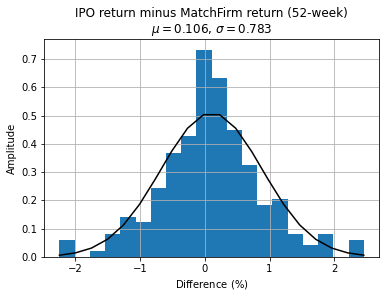

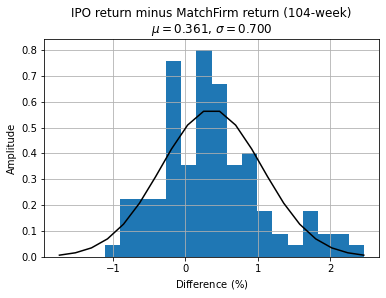

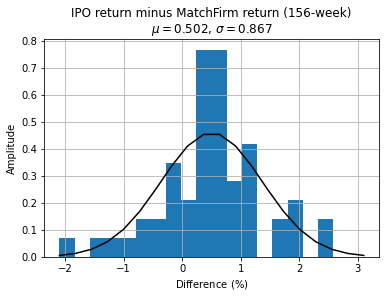

In [21]:
# Generate graphs for difference comparison
for i in range(years):
    plt.figure()
    
    graph = compare_diff[i]['difference'].to_list()
    bins = 20
    xmin, xmax = dist_diff[i][0]-3*dist_diff[i][1], dist_diff[i][0]+3*dist_diff[i][1]
    plt.hist(graph, bins=bins, range=(xmin, xmax), density=True)
    
    x = np.linspace(xmin, xmax, bins)
    fit = norm.pdf(x, dist_diff[i][0], dist_diff[i][1])
    plt.plot(x, fit, 'k')

    plt.title('IPO return minus MatchFirm return ({}-week)\n$\mu={:.3f}$, $\sigma={:.3f}$'.format(holdWeeks[i], dist_diff[i][0], dist_diff[i][1]))
    plt.xlabel('Difference ($\%$)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.savefig('resources/graph_difference_{}week.png'.format(holdWeeks[i]))

In [22]:
# Remove outliers from ratio comparison
compare_ratio = []
dist_ratio = []
outliers_ratio = []

for i in range(years):
    compare_ratio.append(pd.DataFrame())
    compare_ratio[i][['IPO','MatchFirm','Industry']] = filtered[i][['IPO','MatchFirm','Industry']]
    compare_ratio[i]['ratio'] = (filtered[i]['IPO return']+1) / (filtered[i]['MatchFirm return']+1)
    outliers_ratio.append(pd.DataFrame(columns=['IPO','MatchFirm','Industry','ratio']))
    
    while True:
        mu, sigma = norm.fit(np.log10(compare_ratio[i]['ratio'].to_list()))
        if compare_ratio[i].loc[(compare_ratio[i]['ratio'] - mu).apply(np.log10) > 3*sigma, 'ratio'].empty:
            dist_ratio.append((mu, sigma))
            break
        outlier = (compare_ratio[i][['ratio']].apply(np.log10) - mu).apply(abs).idxmax().values[0]
        outliers_ratio[i] = outliers_ratio[i].append(compare_ratio[i].loc[[outlier]])
        compare_ratio[i] = compare_ratio[i].drop([outlier])

outliers_ratio[0]

,IPO,MatchFirm,Industry,ratio
179,1660,8188,Industrials,105.324074
197,1630,442,Consumer Cyclicals,32.166200


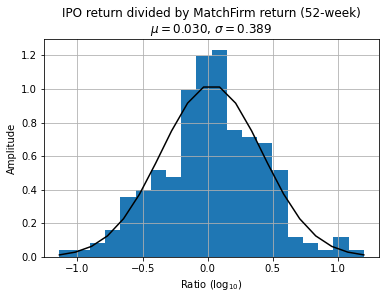

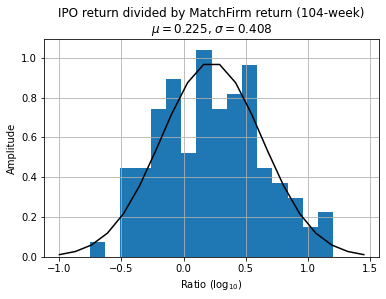

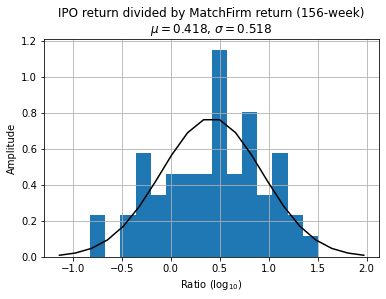

In [23]:
# Generate graphs for difference comparison
for i in range(years):
    plt.figure()
    
    graph = np.log10(compare_ratio[i]['ratio'].to_list())
    bins = 20
    xmin, xmax = dist_ratio[i][0]-3*dist_ratio[i][1], dist_ratio[i][0]+3*dist_ratio[i][1]
    plt.hist(graph, bins=bins, range=(xmin, xmax), density=True)
    
    x = np.linspace(xmin, xmax, bins)
    fit = norm.pdf(x, dist_ratio[i][0], dist_ratio[i][1])
    plt.plot(x, fit, 'k')

    plt.title('IPO return divided by MatchFirm return ({}-week)\n$\mu={:.3f}$, $\sigma={:.3f}$'.format(holdWeeks[i], dist_ratio[i][0], dist_ratio[i][1]))
    plt.xlabel('Ratio ($\log_{10}$)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.savefig('resources/graph_ratio_{}week.png'.format(holdWeeks[i]))

### It is unclear why the "holding" calculation is prefered to find the return. Compounding daily changes should be mathematically the same as taking the average over time. The (lack of) difference between the "holding" calculation and "regular" (averaging) calculation is examined below.

In [24]:
# Create DataFrame to compare peers
diff = pd.DataFrame(columns=['IPO','IPO return diff','MatchFirm','MatchFirm return diff'])

# Calculate return after some weeks of holding
holdWeeks = 52
for index, ipo in data_ipo.iterrows():
    
    name = ipo['Stock']
    industry = ipo['Industry']
    mktcap = ipo['MktCap']
    prevYear = ipo['previous_year']
    
    date = ipo['IPO']
    if datetime.strptime(date, "%Y-%m-%d") + timedelta(weeks=holdWeeks) > datetime.strptime("2020-01-01", "%Y-%m-%d"):
        continue
    
    match = find_matching_firm(eqt_mktcap, industry, mktcap, prevYear)
    matchReturn1 = calculate_return_regular(eqt_price, match, date, holdWeeks)
    matchReturn2 = calculate_return_hold(eqt_daily_return, match, date, holdWeeks)
    ipoReturn1 = calculate_return_regular(ipo_price, name, date, holdWeeks)
    ipoReturn2 = calculate_return_hold(ipo_daily_return, name, date, holdWeeks)
    
    group = {'IPO': name,
             'IPO return diff': abs(ipoReturn1 - ipoReturn2),
             'MatchFirm': match,
             'MatchFirm return diff': abs(matchReturn1 - matchReturn2),}
    diff = diff.append(group, ignore_index=True)

diff

,IPO,IPO return diff,MatchFirm,MatchFirm return diff
0,1353,NaN,8172,3.108624e-15
1,1439,NaN,8227,8.881784e-16
2,1247,NaN,8273,NaN
3,3332,NaN,8273,NaN
4,2080,NaN,736,8.881784e-16
...,...,...,...,...
321,1762,4.440892e-16,8010,0.000000e+00
322,3978,1.554312e-15,8363,1.998401e-15
323,1713,4.440892e-16,1265,2.220446e-16
324,1759,8.881784e-16,1265,2.220446e-16


In [25]:
print("Difference in IPO return calculations")
print(sorted(diff['IPO return diff'].dropna().to_list(), reverse=True)[:5])
print("\nDifference in MatchFirm return calculations")
print(sorted(diff['MatchFirm return diff'].dropna().to_list(), reverse=True)[:5])

Difference in IPO return calculations
[4.973799150320701e-14, 2.3092638912203256e-14, 1.1102230246251565e-14, 7.993605777301127e-15, 5.773159728050814e-15]

Difference in MatchFirm return calculations
[1.1546319456101628e-14, 1.0658141036401503e-14, 7.549516567451064e-15, 6.217248937900877e-15, 5.773159728050814e-15]
